# Initilalizing

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/
%ls

/gdrive/MyDrive
'Colab Notebooks'/                       IncpetionModel1/
 Dataset/                                model.png
 FinalModel/                             S3CRET/
 Gabriele/                               SimpleLSTMForecasting/
 IncpetionFtAugModel1/                   SimplerModel/
 IncpetionFtAugWeighModel1/              StandardModel/
 IncpetionFtAugWeighModel1_more_layer/   training/
 IncpetionFtModel1/


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
import math
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis 

### Load the dataset

In [ ]:
dataset = pd.read_csv('Database/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


Sponginess  Wonder level  ...  Soap slipperiness  Hype root
0     7.97698       4.33494  ...          51.681460    3.65434
1     8.07824       4.44616  ...          51.563598    3.47672
2     8.02844       4.22372  ...          50.863080    3.47672
3     8.02844       4.22372  ...          45.841581    3.47672
4     7.87572       4.44616  ...          47.126421    3.47672

[5 rows x 7 columns]

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


In [ ]:
dataset.describe().transpose()

count       mean  ...        75%        max
Sponginess          68528.0   6.094102  ...   7.067300  15.106680
Wonder level        68528.0   4.695539  ...   7.115440  18.122899
Crunchiness         68528.0  13.337485  ...  20.568080  41.138801
Loudness on impact  68528.0   2.448660  ...   4.656980  14.035980
Meme creativity     68528.0   2.407010  ...   3.021880   6.056360
Soap slipperiness   68528.0  23.237929  ...  31.245199  77.371620
Hype root           68528.0   8.231283  ...  15.334100  31.024420

[7 rows x 8 columns]

In [ ]:
def inspect_dataframe(df, columns, zoom):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col][1:zoom])
        axs[i].set_title(col)
    plt.show()


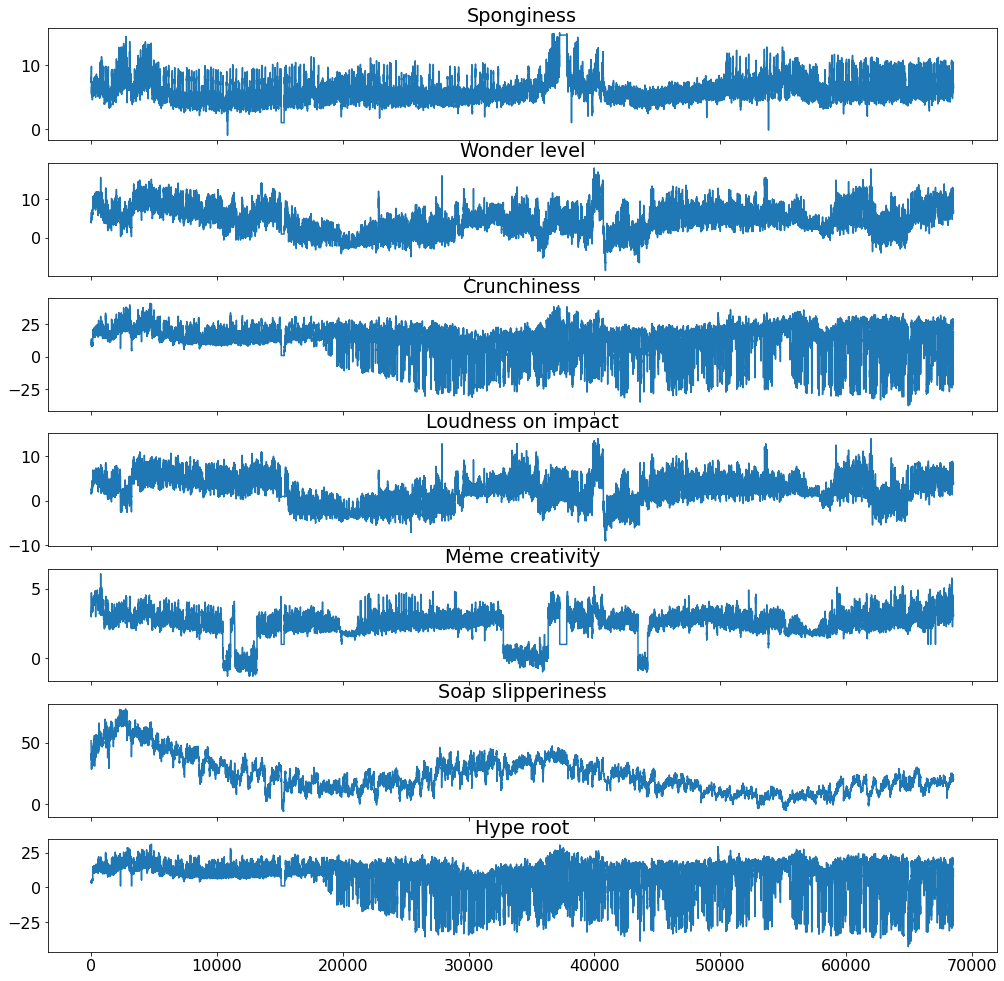

In [ ]:
# Show all the dataset
inspect_dataframe(dataset, dataset.columns, dataset.shape[0])

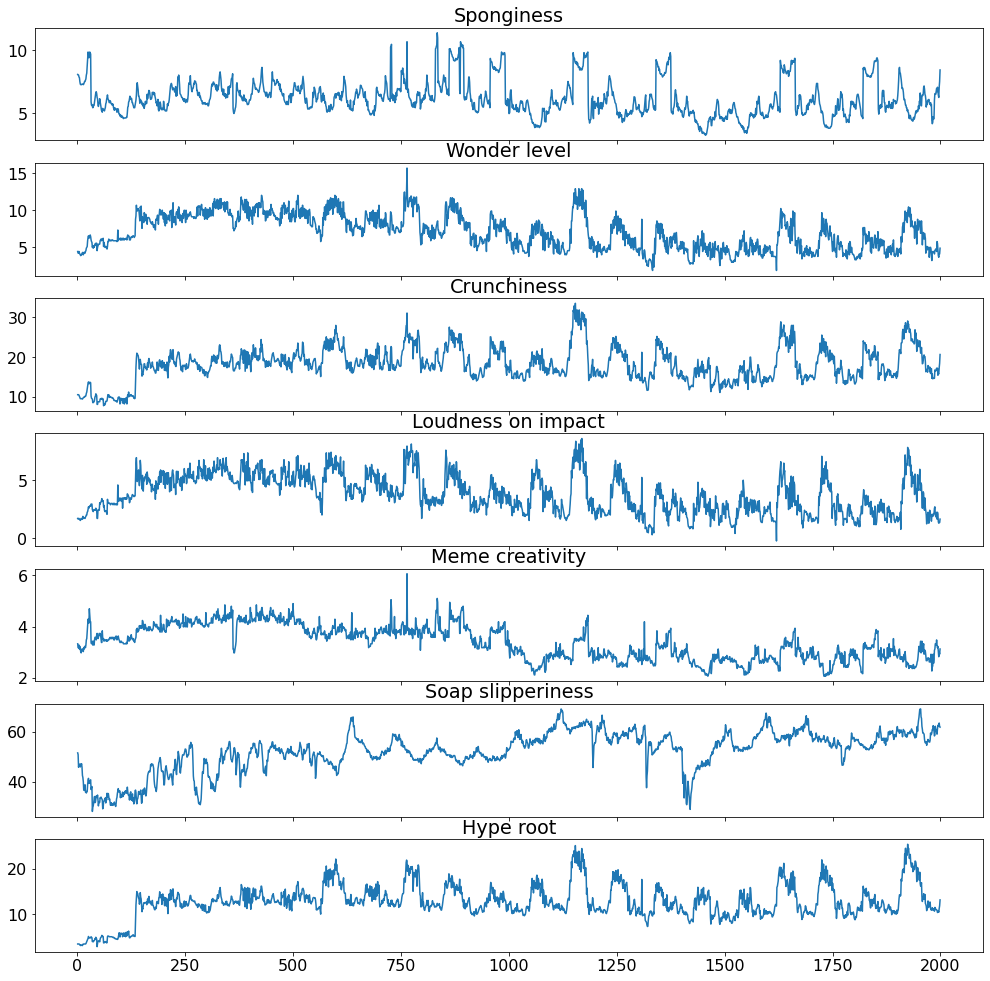

In [ ]:
# Show the first 2000 samples
inspect_dataframe(dataset, dataset.columns, 2000)

# Data preparation

### Normalization


In [ ]:
# Normalize both features and labels
X_min = dataset.min()
X_max = dataset.max()

print(X_min)
print(X_max)

Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -37.581721
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -42.769221
dtype: float64
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [ ]:
dataset_norm = (dataset-X_min)/((X_max-X_min))
dataset_norm.head()

Sponginess  Wonder level  ...  Soap slipperiness  Hype root
0    0.556576      0.481134  ...           0.691885   0.629100
1    0.562874      0.485320  ...           0.690471   0.626693
2    0.559777      0.476949  ...           0.682070   0.626693
3    0.559777      0.476949  ...           0.621844   0.626693
4    0.550279      0.485320  ...           0.637254   0.626693

[5 rows x 7 columns]

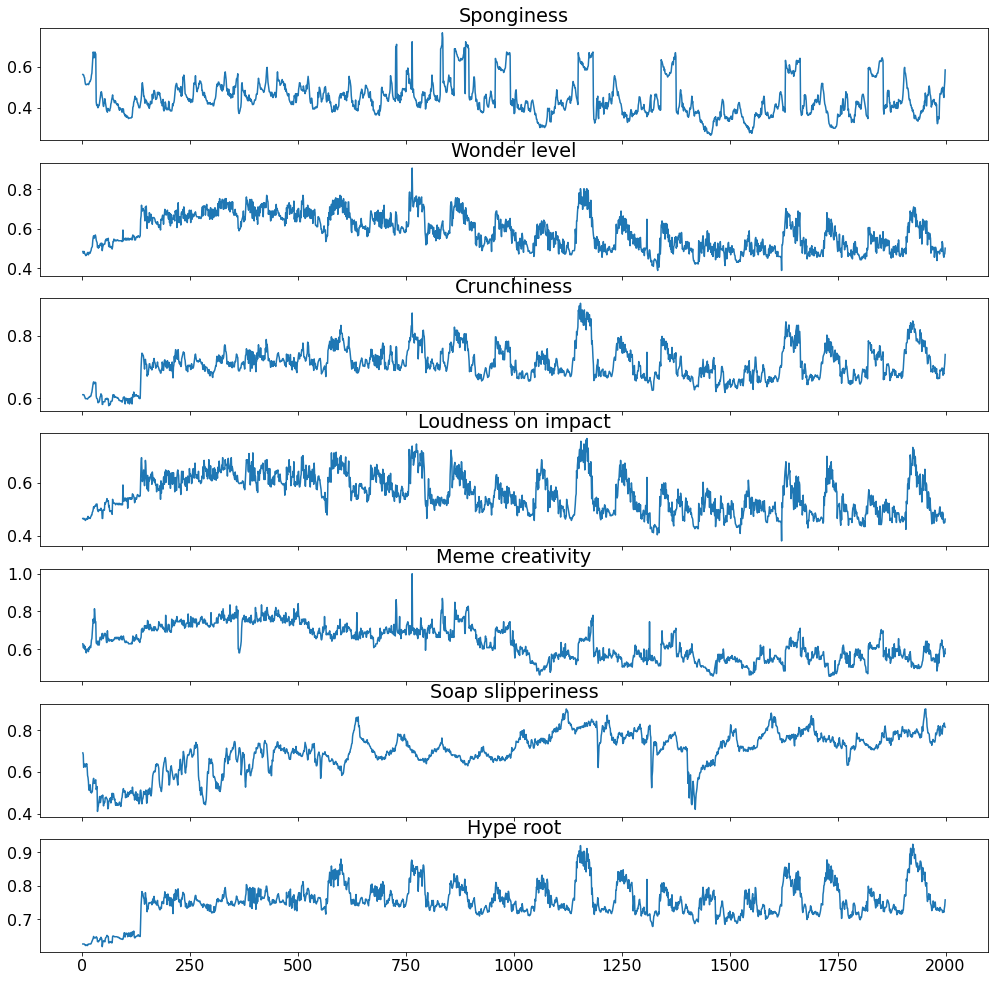

In [ ]:
inspect_dataframe(dataset_norm, dataset_norm.columns, 2000)

### Windowing 


In [ ]:
TELESCOPE = 864
WINDOWS_LENGTH = 2000
VALIDATION_SPLIT = 0.2

In [ ]:
future = dataset_norm[-WINDOWS_LENGTH:]
future = np.expand_dims(future, axis=0)
future.shape

(1, 2000, 7)

In [ ]:
def build_sequences(df, target_labels, window=2000, stride=20, telescope=864): #1156/4 = 288 time-steps into the future
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
target_labels = dataset_norm.columns

In [ ]:
X_train, y_train = build_sequences(dataset_norm, target_labels, window =WINDOWS_LENGTH, telescope = TELESCOPE)
X_val = X_train[-math.floor(len(X_train)*VALIDATION_SPLIT):,:,:]
y_val = y_train[-math.floor(len(y_train)*VALIDATION_SPLIT):,:,:]
X_train = X_train[0:len(X_train)-math.floor(len(X_train)*VALIDATION_SPLIT), : , :] 
y_train = y_train[0:len(y_train)-math.floor(len(y_train)*VALIDATION_SPLIT), : , :]


In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2686, 2000, 7), (2686, 864, 7), (671, 2000, 7), (671, 864, 7))

In [ ]:
X_train.max()

1.0

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

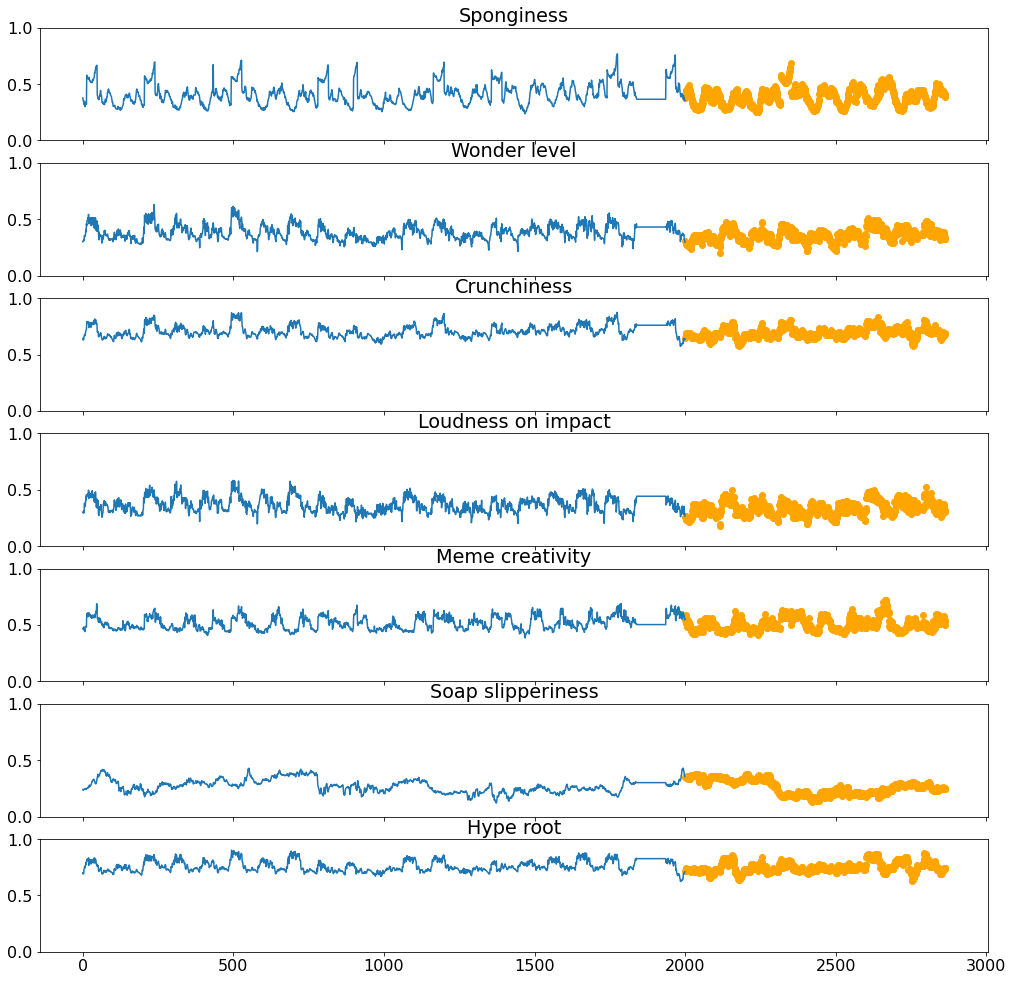

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope=TELESCOPE)

# Baseline Model 1

![Repeat the last input, for each output step](https://www.tensorflow.org/tutorials/structured_data/images/multistep_last.png)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 5

In [ ]:
# Use current label as prediction for the next 864 samples
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs): # dataset dim ((3357, 2000, 7), (3357, 864, 7)) # input dim (1, 2000, 7)
    return tf.tile(inputs[:, -1:, :], [1, TELESCOPE, 1]) 
    # per ognuno dei 3357 input multi(7)-variate samples, prendi l'ultimo timestep (-1:) e copialo TELESCOPE volte
    # tf.tile(input, multiples, name=None)
    # This operation creates a new tensor by replicating input multiples times. 
    #The output tensor's i'th dimension has input.dims(i) * multiples[i] elements, 
    # and the values of input are replicated multiples[i] times along the 'i'th 
    #dimension. For example, tiling [a b c d] by [2] produces [a b c d a b c d].

In [ ]:
baseline_model = MultiStepLastBaseline()
baseline_model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
 history = baseline_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = False,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/5
42/42 [==============================] - 1s 12ms/step - loss: 0.0195 - mean_absolute_error: 0.0973 - root_mean_squared_error: 0.1398 - val_loss: 0.0286 - val_mean_absolute_error: 0.1148 - val_root_mean_squared_error: 0.1691 - lr: 0.0010
Epoch 2/5
42/42 [==============================] - 0s 9ms/step - loss: 0.0195 - mean_absolute_error: 0.0973 - root_mean_squared_error: 0.1398 - val_loss: 0.0286 - val_mean_absolute_error: 0.1148 - val_root_mean_squared_error: 0.1691 - lr: 0.0010
Epoch 3/5
42/42 [==============================] - 0s 9ms/step - loss: 0.0195 - mean_absolute_error: 0.0973 - root_mean_squared_error: 0.1398 - val_loss: 0.0286 - val_mean_absolute_error: 0.1148 - val_root_mean_squared_error: 0.1691 - lr: 0.0010
Epoch 4/5
42/42 [==============================] - 0s 9ms/step - loss: 0.0195 - mean_absolute_error: 0.0973 - root_mean_squared_error: 0.1398 - val_loss: 0.0286 - val_mean_absolute_error: 0.1148 - val_root_mean_squared_error: 0.1691 - lr: 0.0010
Epoch 5/5
42/42

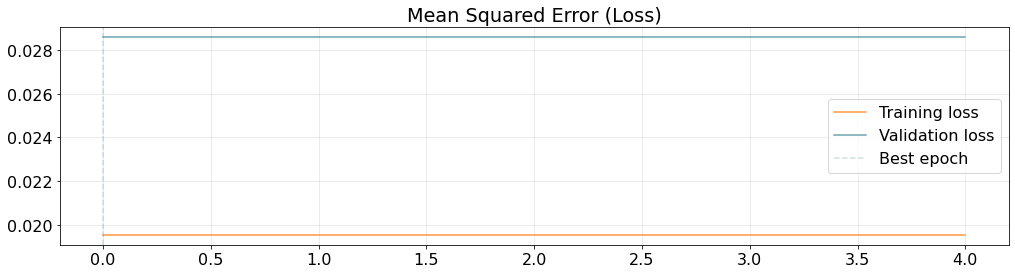

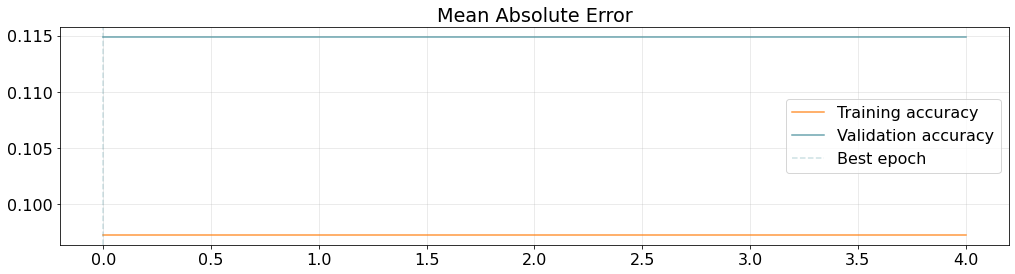

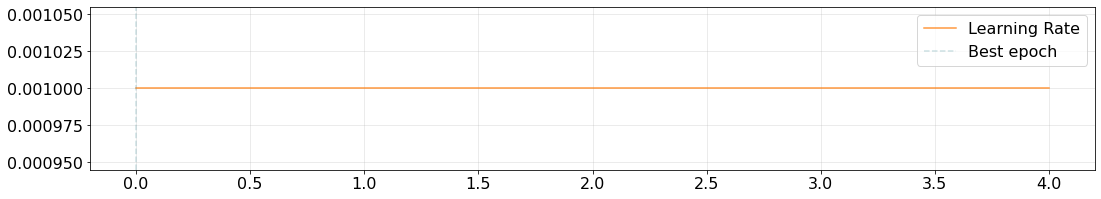

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mean_absolute_error'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mean_absolute_error'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# See prediction on the validation set
predictions = baseline_model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
root_mean_absolute_error =math.sqrt(mean_squared_error)
mean_squared_error, mean_absolute_error, root_mean_absolute_error

(671, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.028582623>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11484498>,
 0.16906396194467568)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

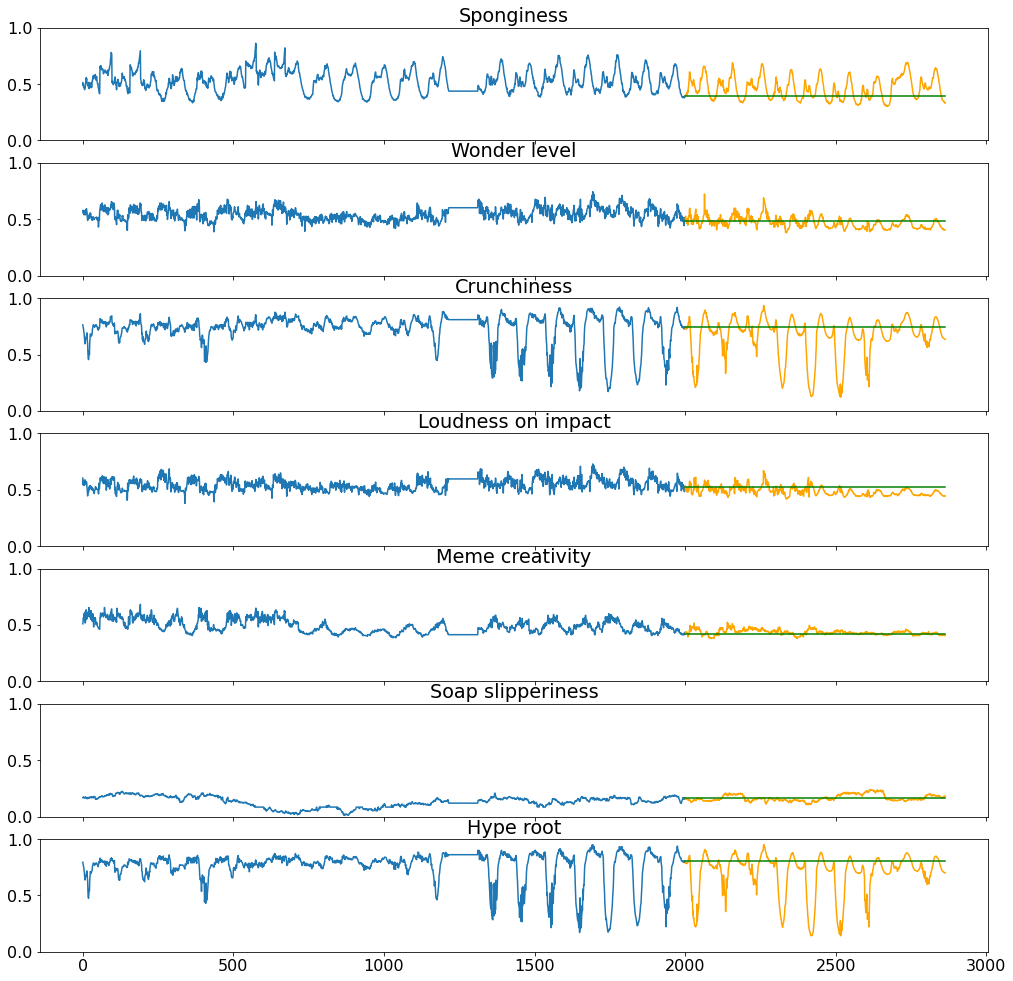

In [ ]:
inspect_multivariate_prediction(X_val, y_val, predictions, target_labels, TELESCOPE)

In [ ]:
# Predict the future 
future_predictions = baseline_model.predict(future)

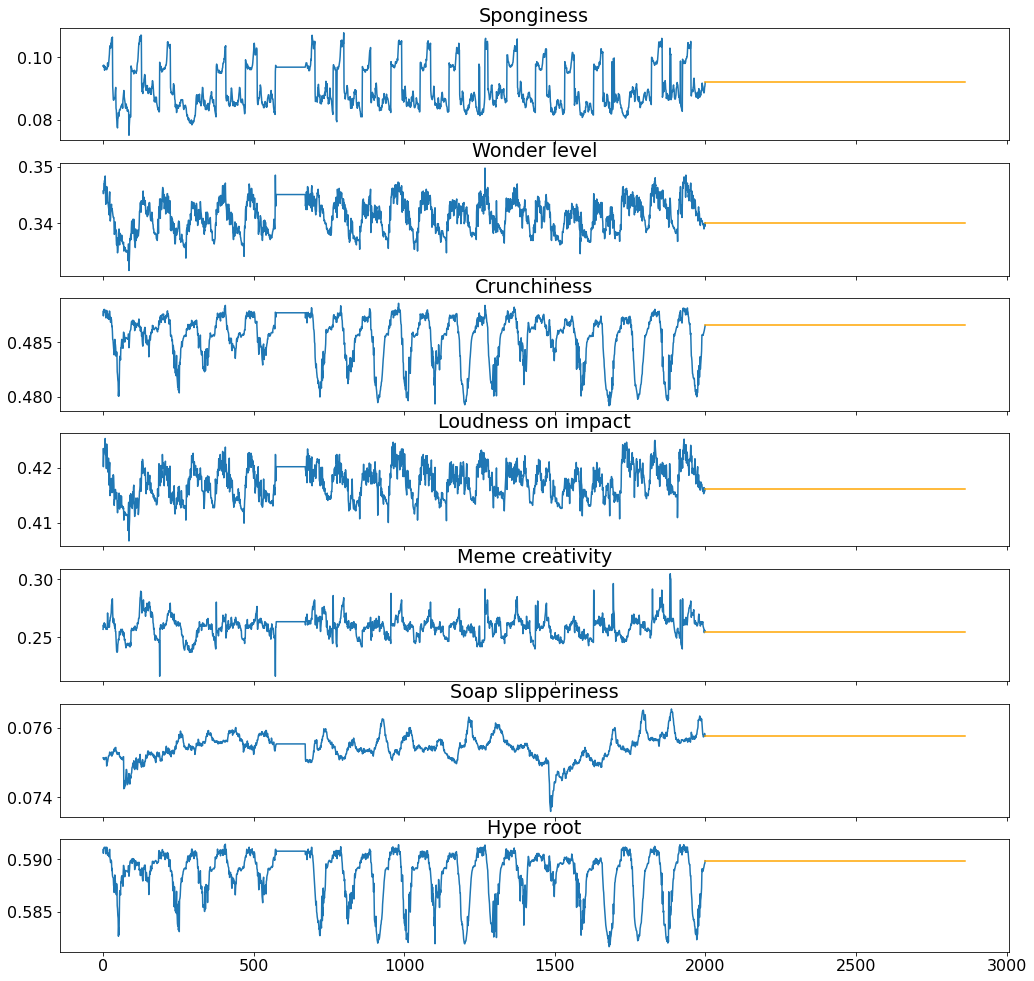

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+TELESCOPE), future_predictions[0,:,i], color='orange')
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

# Baseline Model 2

![Repeat the last 864/1152 input for the next future steps](https://www.tensorflow.org/tutorials/structured_data/images/multistep_repeat.png)

In [ ]:
class MultiStepLastBaseline2(tf.keras.Model):
  def call(self, inputs): # dataset dim ((3357, 2000, 7), (3357, 864, 7)) # input dim (1, 2000, 7)
    return tf.tile(inputs[:, -TELESCOPE:, :], [1, 1, 1]) 

In [ ]:
baseline_model2 = MultiStepLastBaseline2()
baseline_model2.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
 history_2 = baseline_model2.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = False,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/5
42/42 [==============================] - 1s 11ms/step - loss: 0.0158 - mean_absolute_error: 0.0831 - root_mean_squared_error: 0.1257 - val_loss: 0.0148 - val_mean_absolute_error: 0.0826 - val_root_mean_squared_error: 0.1216 - lr: 0.0010
Epoch 2/5
42/42 [==============================] - 0s 9ms/step - loss: 0.0158 - mean_absolute_error: 0.0831 - root_mean_squared_error: 0.1257 - val_loss: 0.0148 - val_mean_absolute_error: 0.0826 - val_root_mean_squared_error: 0.1216 - lr: 0.0010
Epoch 3/5
42/42 [==============================] - 0s 8ms/step - loss: 0.0158 - mean_absolute_error: 0.0831 - root_mean_squared_error: 0.1257 - val_loss: 0.0148 - val_mean_absolute_error: 0.0826 - val_root_mean_squared_error: 0.1216 - lr: 0.0010
Epoch 4/5
42/42 [==============================] - 0s 8ms/step - loss: 0.0158 - mean_absolute_error: 0.0831 - root_mean_squared_error: 0.1257 - val_loss: 0.0148 - val_mean_absolute_error: 0.0826 - val_root_mean_squared_error: 0.1216 - lr: 0.0010
Epoch 5/5
42/42

In [ ]:
# See prediction on the validation set
predictions = baseline_model2.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
root_mean_absolute_error =math.sqrt(mean_squared_error)
mean_squared_error, mean_absolute_error, root_mean_absolute_error

(671, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.01479577>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08260366>,
 0.12163786391307785)

Compared with baseline 1


```
(<tf.Tensor: shape=(), dtype=float32, numpy=0.028582623>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.11484498>,
 0.16906396194467568)
```



 the above score are better. Baseline 2 will be used as baseline

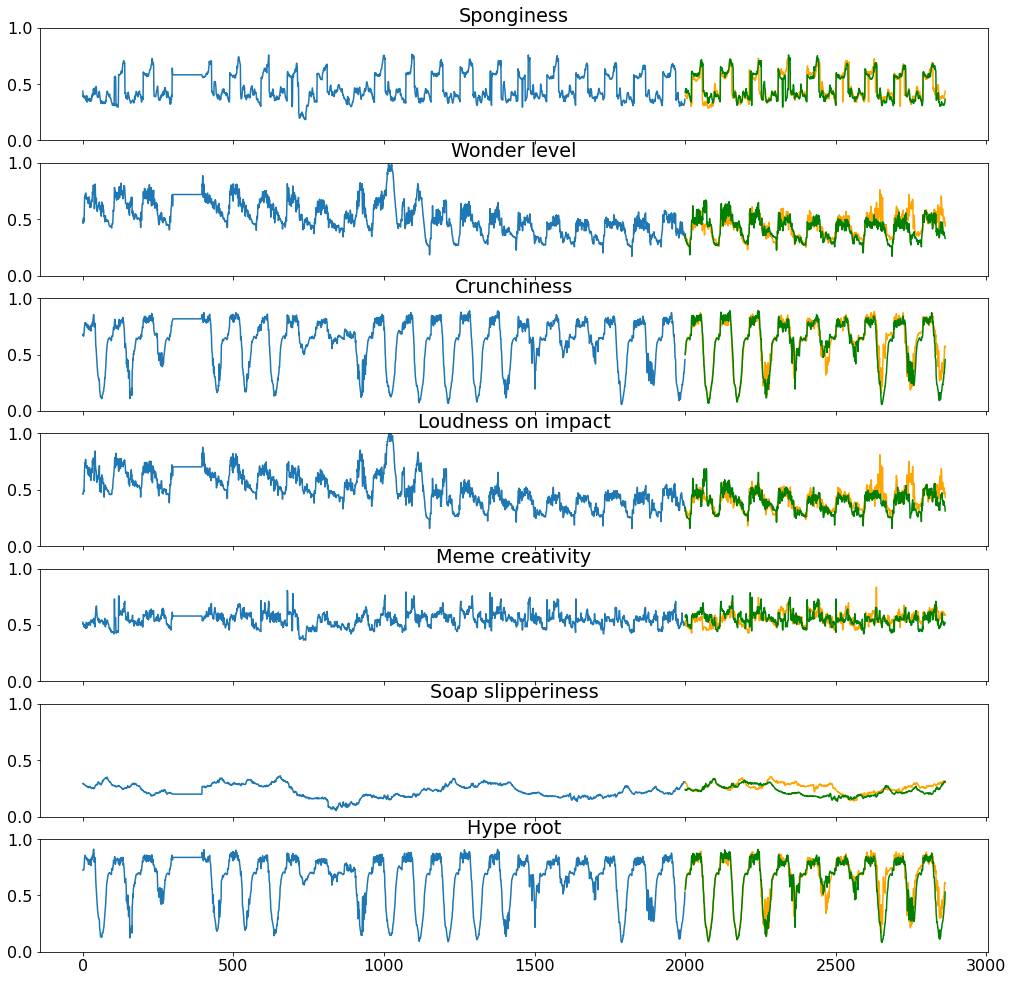

In [ ]:
inspect_multivariate_prediction(X_val, y_val, predictions, target_labels, TELESCOPE)

In [ ]:
# Predict the future 
future_predictions = baseline_model2.predict(future)

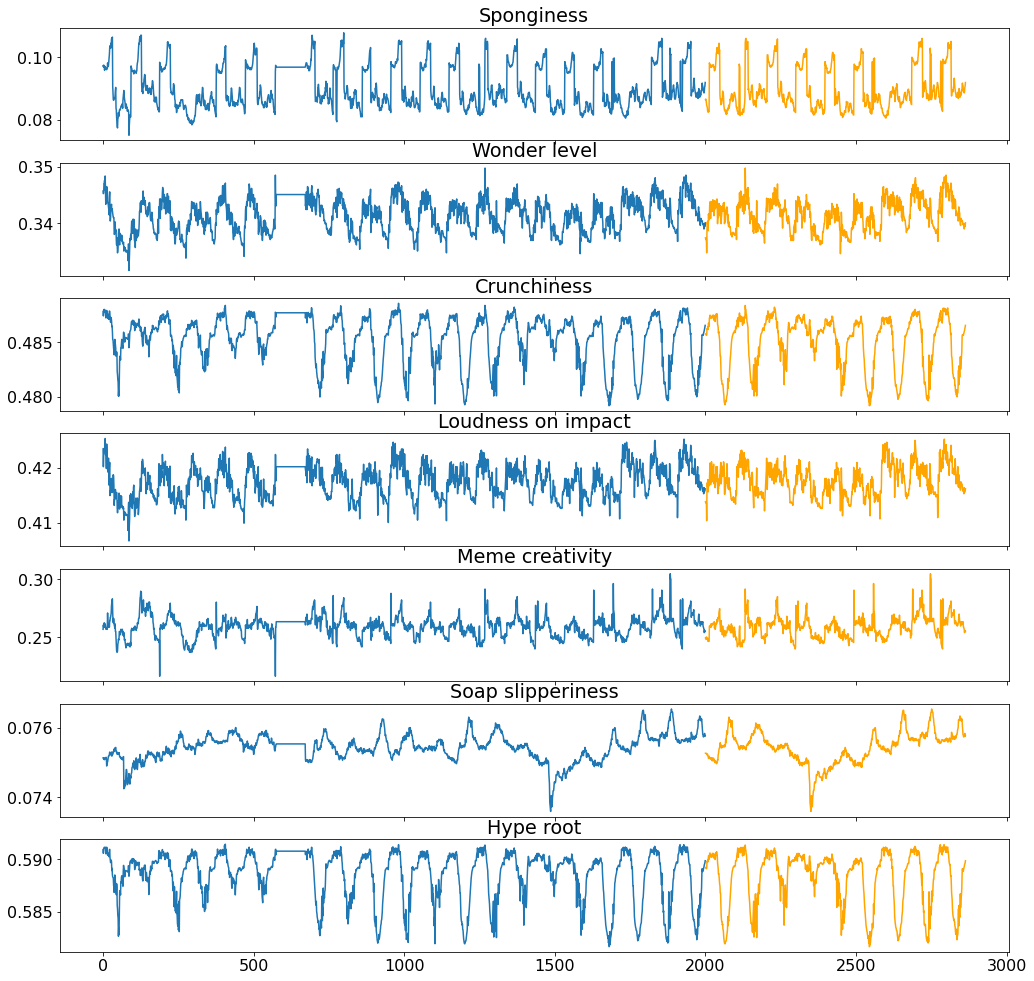

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+TELESCOPE), future_predictions[0,:,i], color='orange')
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

# Single-shot model

## Linear

![Repeat the last 864/1152 input for the next future steps](https://www.tensorflow.org/tutorials/structured_data/images/multistep_dense.png)

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(TELESCOPE*7,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([TELESCOPE, 7])
])

multi_linear_model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
 epochs= 200
 history_3 = multi_linear_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = False,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
42/42 [==============================] - 1s 16ms/step - loss: 0.2017 - mean_absolute_error: 0.4094 - root_mean_squared_error: 0.4491 - val_loss: 0.1285 - val_mean_absolute_error: 0.3163 - val_root_mean_squared_error: 0.3585 - lr: 0.0010
Epoch 2/200
42/42 [==============================] - 0s 11ms/step - loss: 0.0886 - mean_absolute_error: 0.2550 - root_mean_squared_error: 0.2977 - val_loss: 0.0542 - val_mean_absolute_error: 0.1920 - val_root_mean_squared_error: 0.2328 - lr: 0.0010
Epoch 3/200
42/42 [==============================] - 0s 11ms/step - loss: 0.0366 - mean_absolute_error: 0.1560 - root_mean_squared_error: 0.1912 - val_loss: 0.0259 - val_mean_absolute_error: 0.1277 - val_root_mean_squared_error: 0.1609 - lr: 0.0010
Epoch 4/200
42/42 [==============================] - 0s 11ms/step - loss: 0.0207 - mean_absolute_error: 0.1134 - root_mean_squared_error: 0.1440 - val_loss: 0.0214 - val_mean_absolute_error: 0.1118 - val_root_mean_squared_error: 0.1462 - lr: 0.0010
Epoc

In [ ]:
# See prediction on the validation set
predictions = multi_linear_model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
root_mean_absolute_error =math.sqrt(mean_squared_error)
mean_squared_error, mean_absolute_error, root_mean_absolute_error

(671, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.015671069>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09015219>,
 0.12518413958036348)

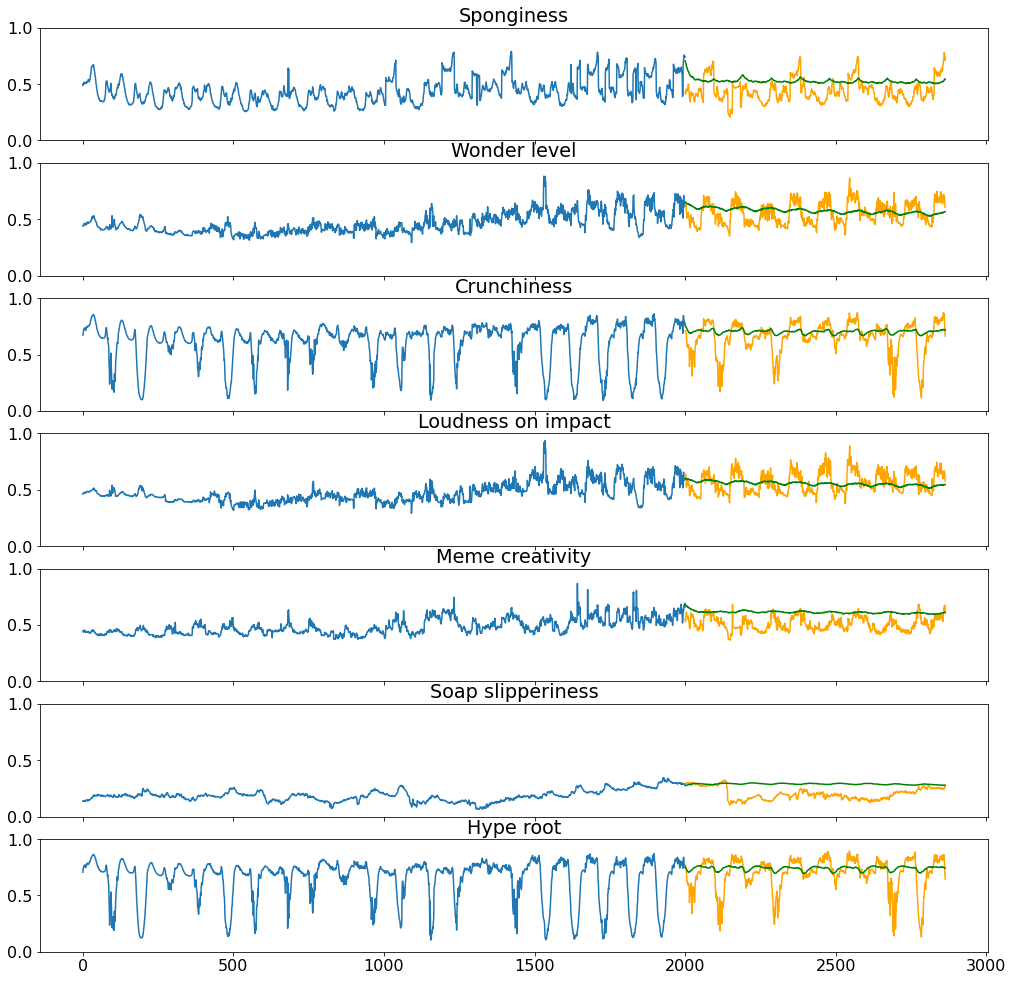

In [ ]:
inspect_multivariate_prediction(X_val, y_val, predictions, target_labels, TELESCOPE)

## Dense

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(TELESCOPE*7,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([TELESCOPE, 7])
])
multi_dense_model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
epochs= 200
history_4 = multi_dense_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = False,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
42/42 [==============================] - 5s 88ms/step - loss: 0.0514 - mean_absolute_error: 0.1555 - root_mean_squared_error: 0.2267 - val_loss: 0.0207 - val_mean_absolute_error: 0.1065 - val_root_mean_squared_error: 0.1440 - lr: 0.0010
Epoch 2/200
42/42 [==============================] - 3s 62ms/step - loss: 0.0166 - mean_absolute_error: 0.0938 - root_mean_squared_error: 0.1288 - val_loss: 0.0190 - val_mean_absolute_error: 0.1017 - val_root_mean_squared_error: 0.1379 - lr: 0.0010
Epoch 3/200
42/42 [==============================] - 3s 62ms/step - loss: 0.0156 - mean_absolute_error: 0.0906 - root_mean_squared_error: 0.1249 - val_loss: 0.0182 - val_mean_absolute_error: 0.0988 - val_root_mean_squared_error: 0.1350 - lr: 0.0010
Epoch 4/200
42/42 [==============================] - 3s 61ms/step - loss: 0.0149 - mean_absolute_error: 0.0883 - root_mean_squared_error: 0.1221 - val_loss: 0.0178 - val_mean_absolute_error: 0.0969 - val_root_mean_squared_error: 0.1334 - lr: 0.0010
Epoc

In [ ]:
# See prediction on the validation set
predictions = multi_dense_model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
root_mean_absolute_error =math.sqrt(mean_squared_error)
mean_squared_error, mean_absolute_error, root_mean_absolute_error

(671, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0145382155>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.085904345>,
 0.12057452248835265)

Offer result comparable to the baseline 2


```
(671, 864, 7)
(<tf.Tensor: shape=(), dtype=float32, numpy=0.01479577>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08260366>,
 0.12163786391307785)
```



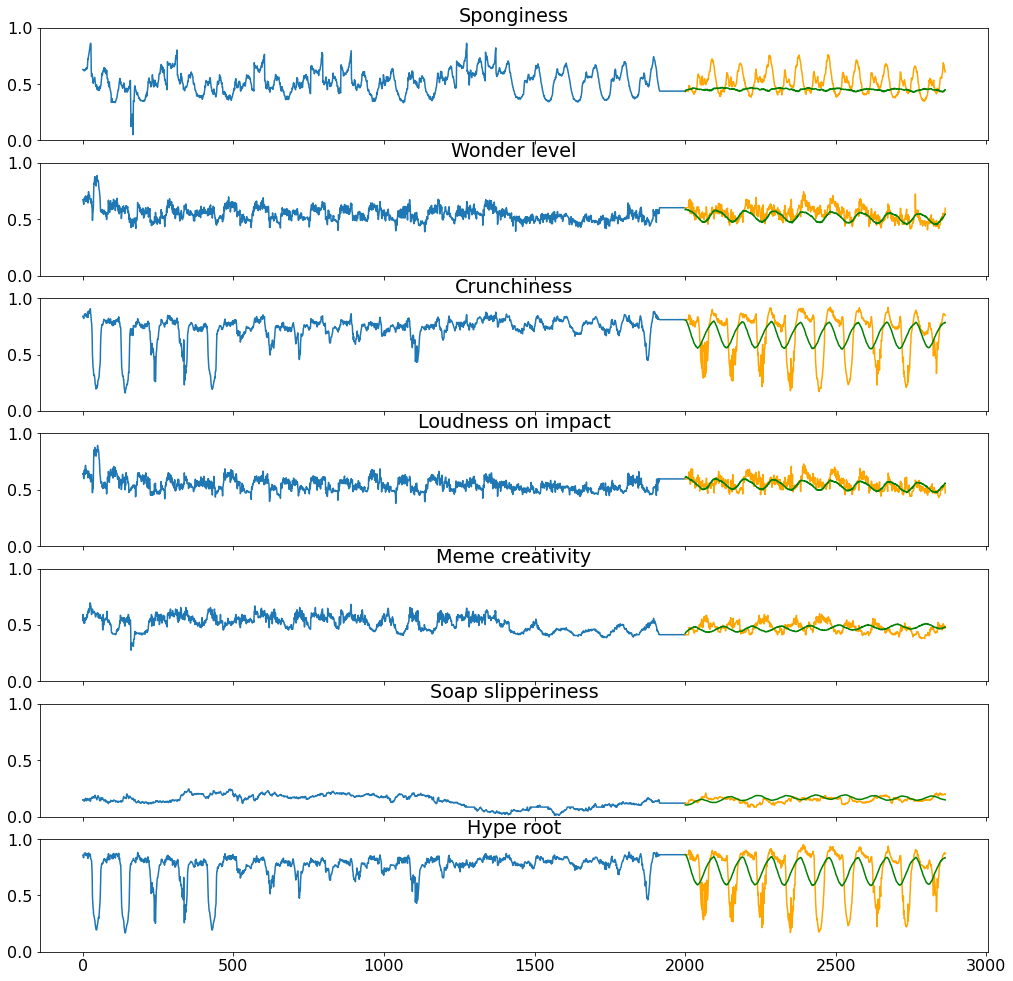

In [ ]:
inspect_multivariate_prediction(X_val, y_val, predictions, target_labels, TELESCOPE)

## CNN

![Repeat the last 864/1152 input for the next future steps](https://www.tensorflow.org/tutorials/structured_data/images/multistep_conv.png)

In [ ]:
CONV_WIDTH = 2000
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(TELESCOPE*7,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([TELESCOPE, 7])
])

multi_conv_model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
epochs= 200
history_5 = multi_conv_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = False,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
42/42 [==============================] - 8s 186ms/step - loss: 0.0130 - mean_absolute_error: 0.0876 - root_mean_squared_error: 0.1142 - val_loss: 0.0125 - val_mean_absolute_error: 0.0849 - val_root_mean_squared_error: 0.1118 - lr: 6.2500e-05
Epoch 2/200
42/42 [==============================] - 10s 251ms/step - loss: 0.0126 - mean_absolute_error: 0.0856 - root_mean_squared_error: 0.1121 - val_loss: 0.0126 - val_mean_absolute_error: 0.0851 - val_root_mean_squared_error: 0.1121 - lr: 6.2500e-05
Epoch 3/200
42/42 [==============================] - 10s 250ms/step - loss: 0.0124 - mean_absolute_error: 0.0850 - root_mean_squared_error: 0.1115 - val_loss: 0.0126 - val_mean_absolute_error: 0.0852 - val_root_mean_squared_error: 0.1121 - lr: 6.2500e-05
Epoch 4/200
42/42 [==============================] - 7s 177ms/step - loss: 0.0123 - mean_absolute_error: 0.0846 - root_mean_squared_error: 0.1110 - val_loss: 0.0126 - val_mean_absolute_error: 0.0852 - val_root_mean_squared_error: 0.1122

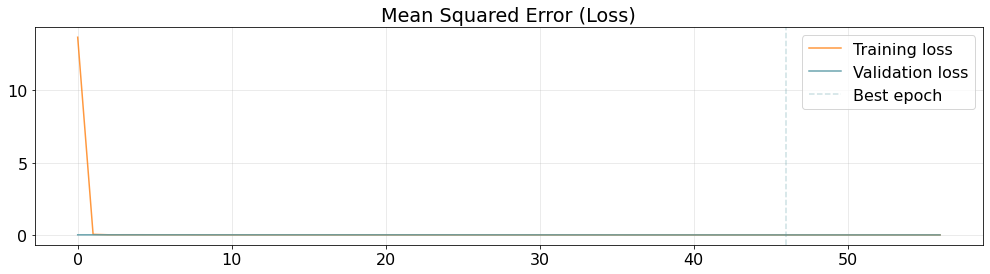

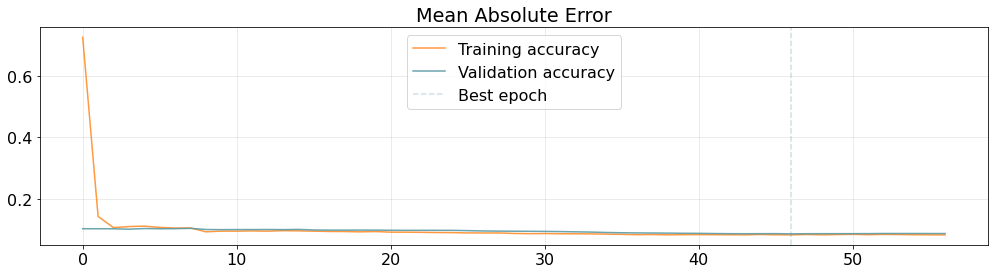

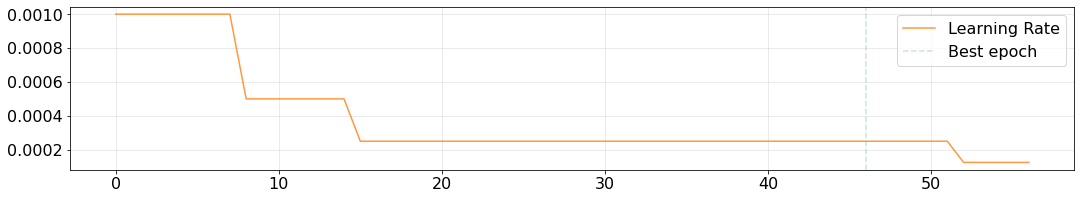

In [ ]:
best_epoch = np.argmin(history_5['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history_5['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history_5['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history_5['mean_absolute_error'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history_5['val_mean_absolute_error'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history_5['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# See prediction on the validation set
predictions = multi_conv_model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
root_mean_absolute_error =math.sqrt(mean_squared_error)
mean_squared_error, mean_absolute_error, root_mean_absolute_error

(671, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.012500697>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08514055>,
 0.11180651508543824)

also this is comparable to the baseline


```
(671, 864, 7)
(<tf.Tensor: shape=(), dtype=float32, numpy=0.01479577>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.08260366>,
 0.12163786391307785)
```



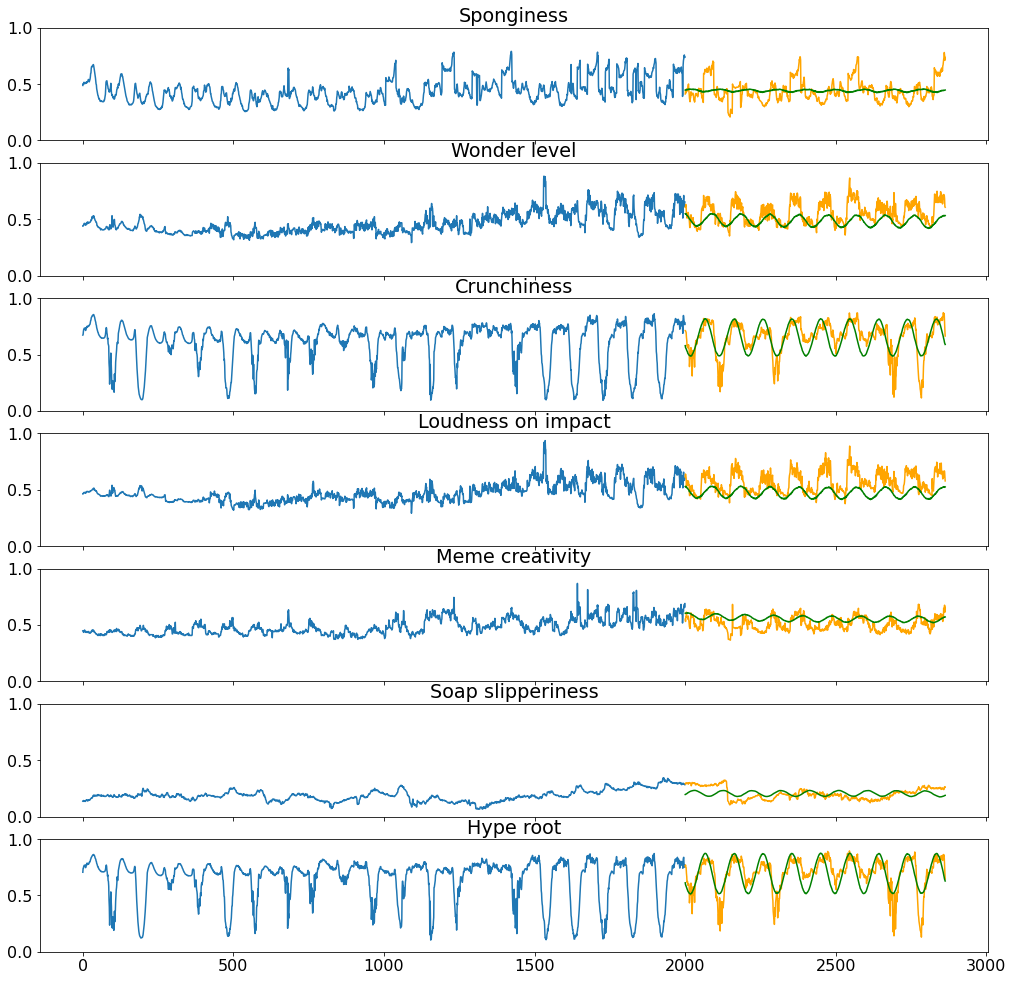

In [ ]:
inspect_multivariate_prediction(X_val, y_val, predictions, target_labels, TELESCOPE)

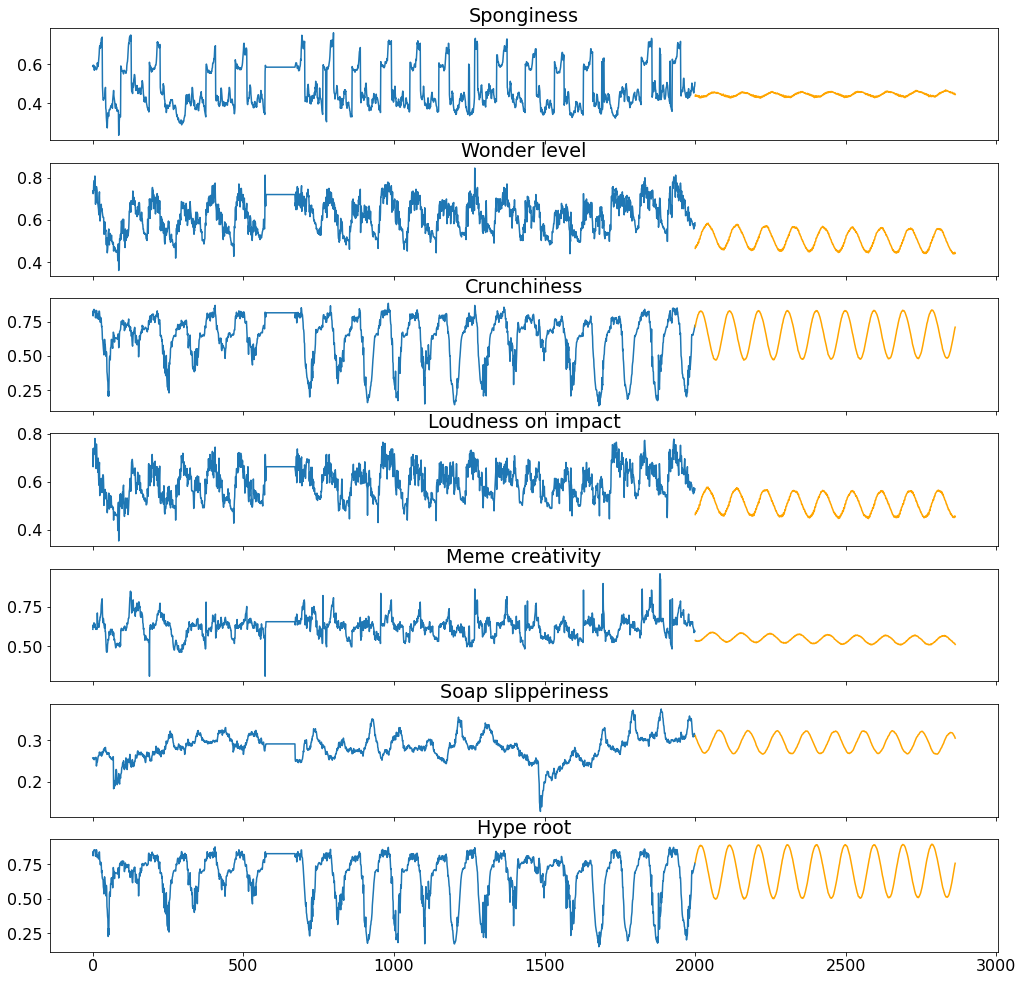

In [ ]:
# Predict the future 
future_predictions = multi_conv_model.predict(future)
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+TELESCOPE), future_predictions[0,:,i], color='orange')
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

## RNN

![Repeat the last 864/1152 input for the next future steps](https://www.tensorflow.org/tutorials/structured_data/images/multistep_lstm.png)

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(TELESCOPE*7,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([TELESCOPE, 7])
])

multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
epochs= 200
history_6 = multi_lstm_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = False,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
42/42 [==============================] - 48s 1s/step - loss: 0.0168 - mean_absolute_error: 0.0960 - root_mean_squared_error: 0.1294 - val_loss: 0.0183 - val_mean_absolute_error: 0.0979 - val_root_mean_squared_error: 0.1352 - lr: 0.0010
Epoch 2/200
42/42 [==============================] - 33s 790ms/step - loss: 0.0176 - mean_absolute_error: 0.0965 - root_mean_squared_error: 0.1327 - val_loss: 0.0183 - val_mean_absolute_error: 0.0978 - val_root_mean_squared_error: 0.1351 - lr: 0.0010
Epoch 3/200
42/42 [==============================] - 34s 805ms/step - loss: 0.0176 - mean_absolute_error: 0.0963 - root_mean_squared_error: 0.1326 - val_loss: 0.0182 - val_mean_absolute_error: 0.0976 - val_root_mean_squared_error: 0.1350 - lr: 0.0010
Epoch 4/200
42/42 [==============================] - 34s 812ms/step - loss: 0.0175 - mean_absolute_error: 0.0961 - root_mean_squared_error: 0.1324 - val_loss: 0.0182 - val_mean_absolute_error: 0.0975 - val_root_mean_squared_error: 0.1349 - lr: 0.0010

In [ ]:
#multi_lstm_model.save('SimpleLSTMForecasting')
multi_lstm_model = tfk.models.load_model('SimpleLSTMForecasting')

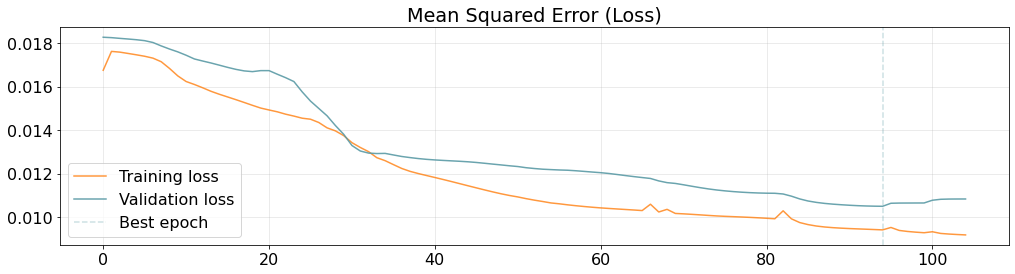

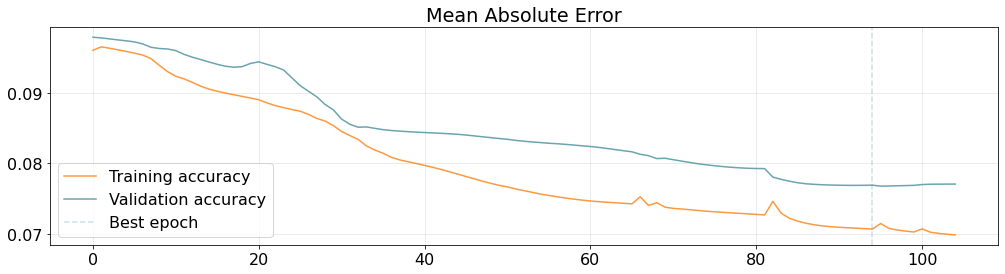

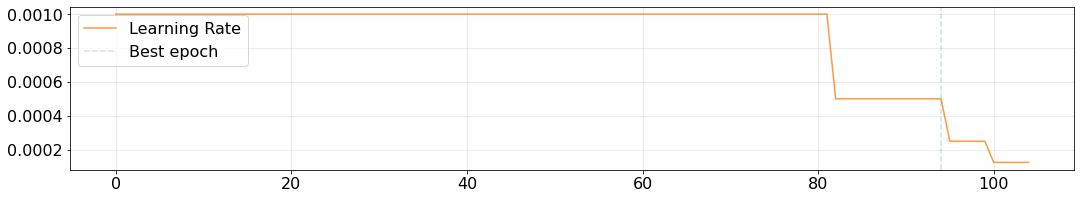

In [ ]:
best_epoch = np.argmin(history_6['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history_6['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history_6['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history_6['mean_absolute_error'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history_6['val_mean_absolute_error'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history_6['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# See prediction on the validation set
predictions = multi_lstm_model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
root_mean_absolute_error =math.sqrt(mean_squared_error)
mean_squared_error, mean_absolute_error, root_mean_absolute_error

(671, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0105002085>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.07689807>,
 0.10247052490690034)

This beat the baseline

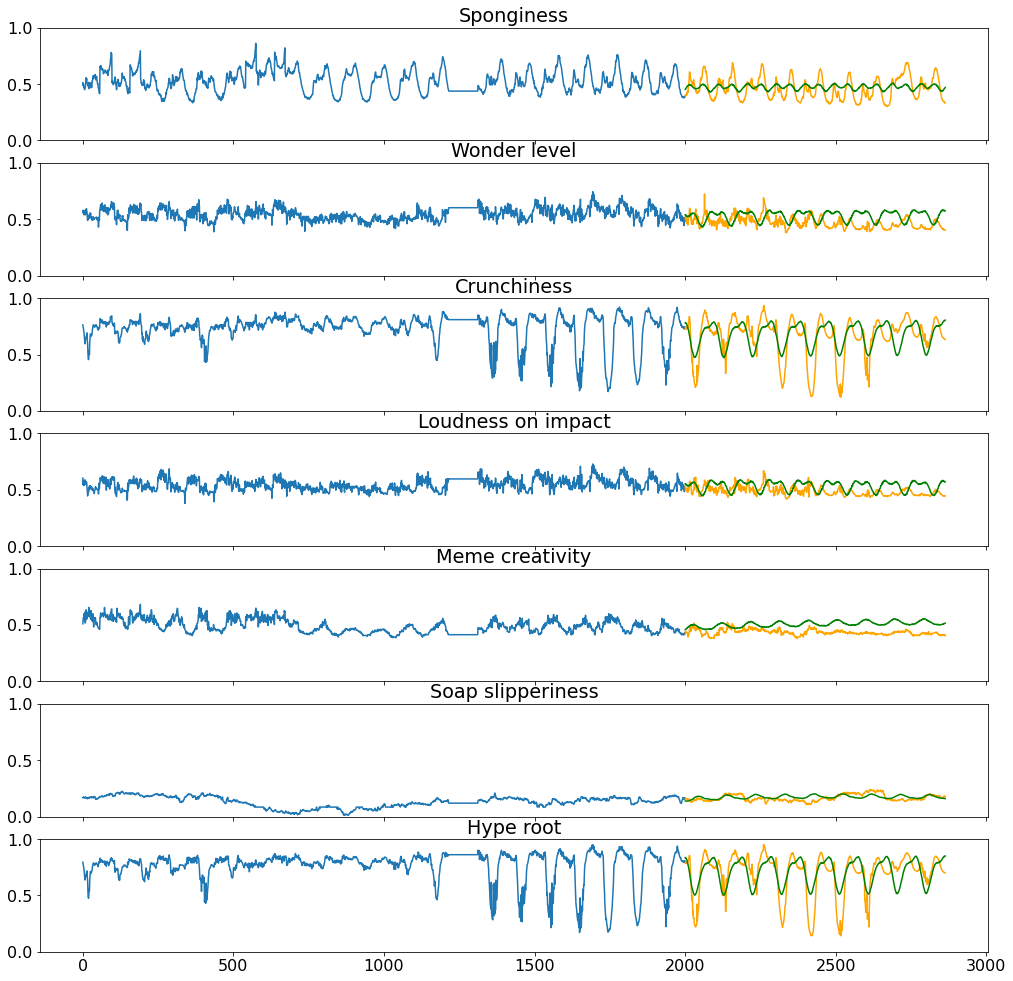

In [ ]:
inspect_multivariate_prediction(X_val, y_val, predictions, target_labels, TELESCOPE)

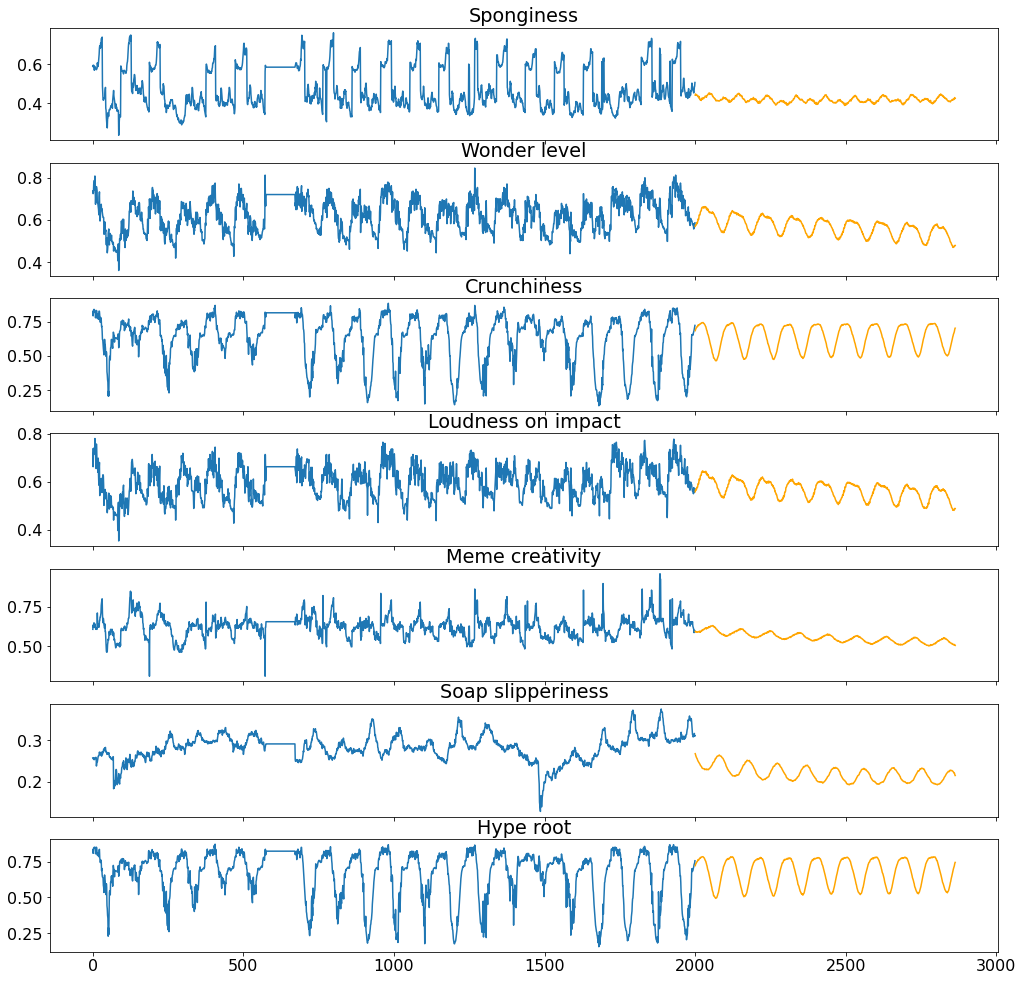

In [ ]:
# Predict the future 
future_predictions = multi_lstm_model.predict(future)
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+TELESCOPE), future_predictions[0,:,i], color='orange')
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        #axs[i].set_ylim(-20,30)
    plt.show()

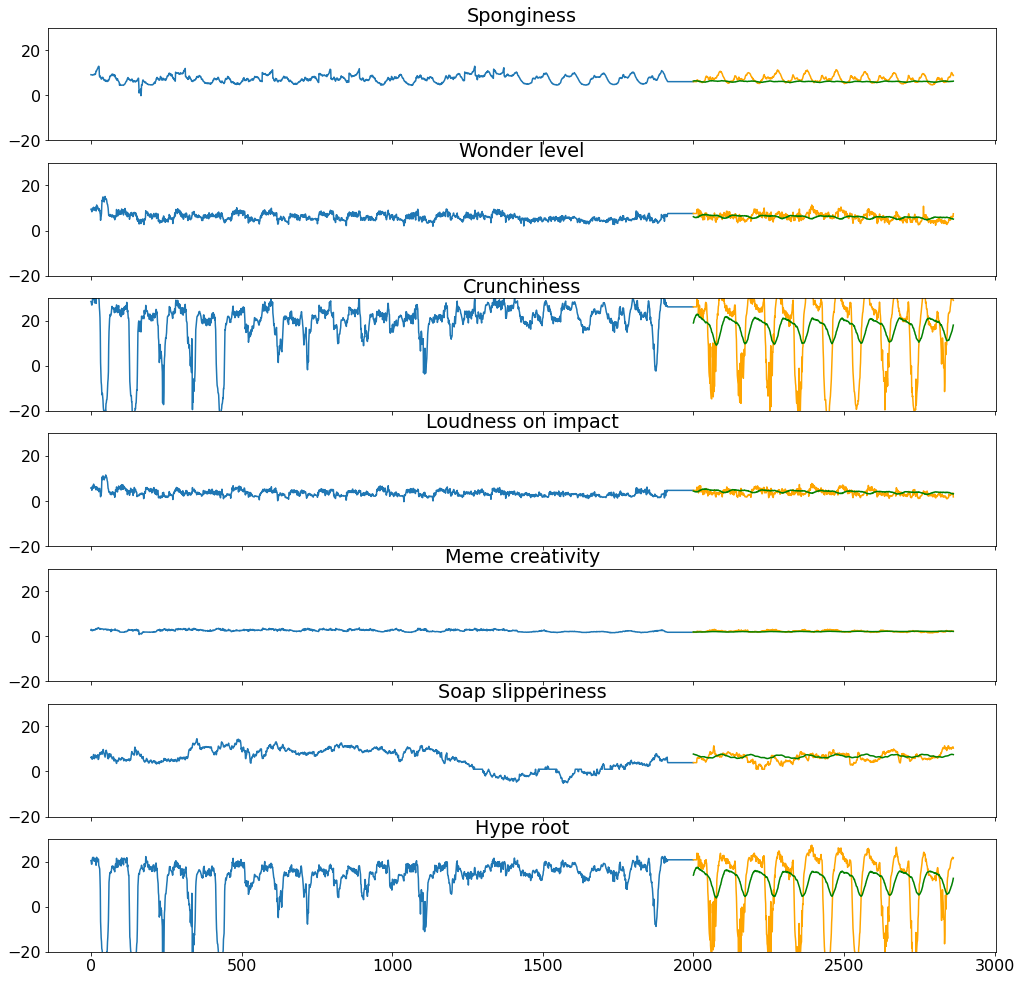

In [ ]:
# Scale up prediction
X_val_up = np.array(X_val)*(np.array(X_max)-np.array(X_min))+np.array(X_min)
y_val_up = np.array(y_val)*(np.array(X_max)-np.array(X_min))+np.array(X_min)
predictions_up = np.array(predictions)*(np.array(X_max)-np.array(X_min))+np.array(X_min)
inspect_multivariate_prediction(X_val_up, y_val_up, predictions_up, target_labels, TELESCOPE)

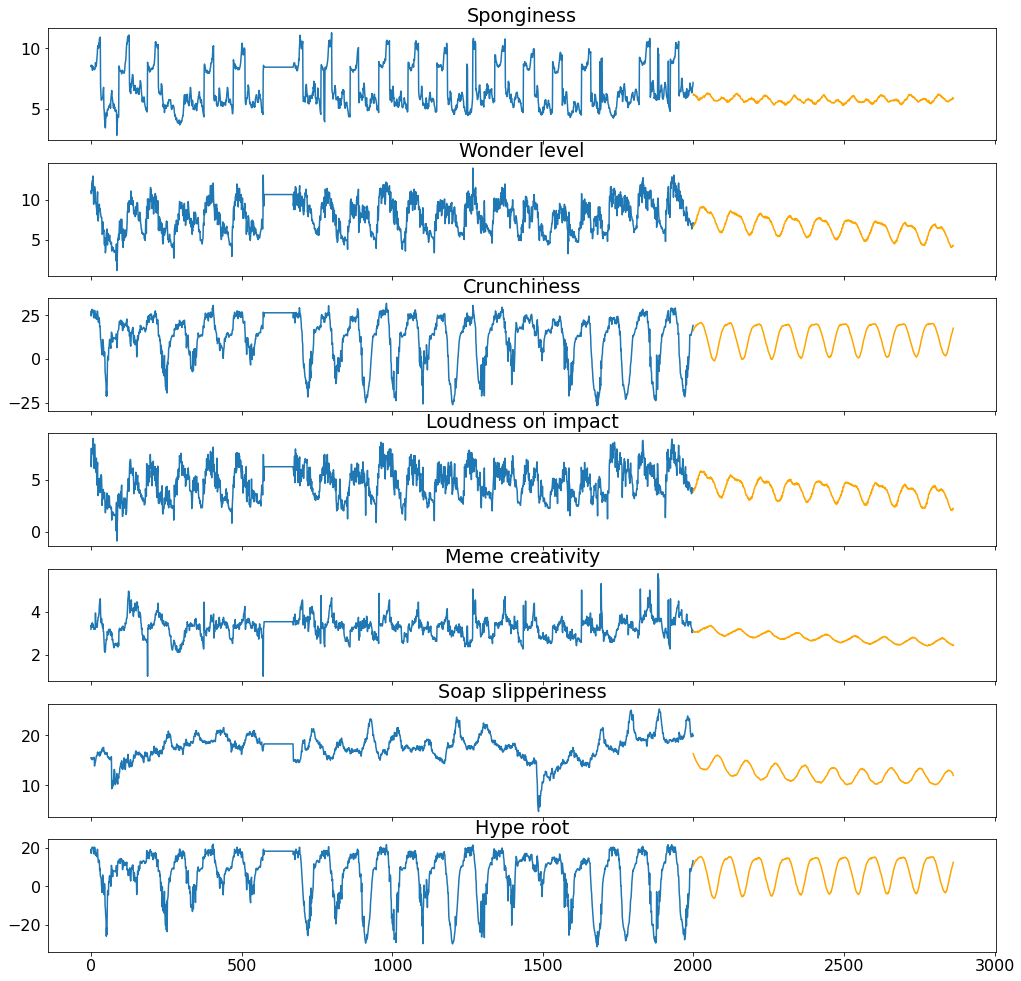

In [ ]:
# Predict the future (scaled up)
future_predictions = multi_lstm_model.predict(future)
future_up = np.array(future)*(np.array(X_max)-np.array(X_min))+np.array(X_min)
future_predictions_up = np.array(future_predictions)*(np.array(X_max)-np.array(X_min))+np.array(X_min)
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future_up[0,:,i])), future_up[0,:,i])
    axs[i].plot(np.arange(len(future_up[0,:,i]), len(future_up[0,:,i])+TELESCOPE), future_predictions_up[0,:,i], color='orange')
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

In [ ]:
future_predictions[0,:,:].shape

(864, 7)

In [ ]:
future.shape

(1, 2000, 7)

# Autoregressive model

![Repeat the last 864/1152 input for the next future steps](https://www.tensorflow.org/tutorials/structured_data/images/multistep_autoregressive.png)

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(7)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=TELESCOPE)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup


In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
feedback_model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])
epochs= 10
history_7 = feedback_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    shuffle = False,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history


# prova con questo
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

Epoch 1/10
42/42 [==============================] - 421s 5s/step - loss: 0.0170 - mean_absolute_error: 0.0975 - root_mean_squared_error: 0.1304 - val_loss: 0.0183 - val_mean_absolute_error: 0.0991 - val_root_mean_squared_error: 0.1351 - lr: 0.0010
Epoch 2/10
42/42 [==============================] - 201s 5s/step - loss: 0.0168 - mean_absolute_error: 0.0938 - root_mean_squared_error: 0.1296 - val_loss: 0.0185 - val_mean_absolute_error: 0.0994 - val_root_mean_squared_error: 0.1361 - lr: 0.0010
Epoch 3/10
42/42 [==============================] - 199s 5s/step - loss: 0.0165 - mean_absolute_error: 0.0926 - root_mean_squared_error: 0.1285 - val_loss: 0.0186 - val_mean_absolute_error: 0.0997 - val_root_mean_squared_error: 0.1365 - lr: 0.0010
Epoch 4/10
42/42 [==============================] - 199s 5s/step - loss: 0.0164 - mean_absolute_error: 0.0920 - root_mean_squared_error: 0.1280 - val_loss: 0.0187 - val_mean_absolute_error: 0.0999 - val_root_mean_squared_error: 0.1368 - lr: 0.0010
Epoch 5/

In [ ]:
# See prediction on the validation set
predictions = feedback_model.predict(X_val)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_val.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_val.flatten(),predictions.flatten())
root_mean_absolute_error =math.sqrt(mean_squared_error)
mean_squared_error, mean_absolute_error, root_mean_absolute_error

(671, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.018264428>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.09770178>,
 0.13514594992490542)

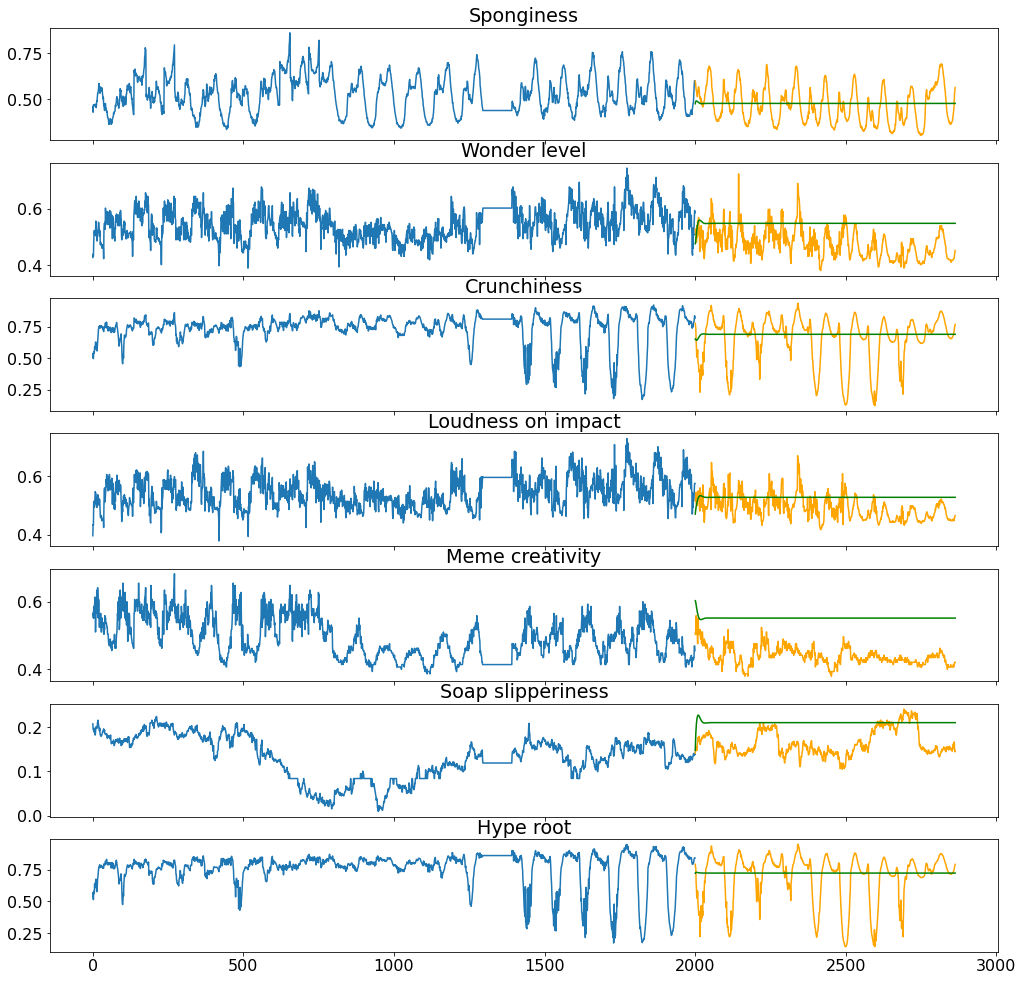

In [ ]:
inspect_multivariate_prediction(X_val, y_val, predictions, target_labels, TELESCOPE)

# Code for Codalab upload

In [ ]:
multi_lstm_model = tfk.models.load_model('SimpleLSTMForecasting')

In [ ]:
## Insert your preprocessing here
TELESCOPE = 864
WINDOWS_LENGTH = 2000

X = np.array(dataset)

# Normalize 
X_min = X.min(axis=0)
X_max = X.max(axis=0)
print(X_min)
print(X_max)
X_norm = (X-X_min)/(X_max-X_min)
#X_norm.head()

future = X_norm[-WINDOWS_LENGTH:]
future = np.expand_dims(future, axis=0)
future_up = future*(X_max-X_min)+X_min

## Predict
out_norm = multi_lstm_model.predict(future)

## Insert your postprocessing here TODO

# Denormalize
out = out_norm*(X_max-X_min)+X_min
out = out[0, :, :]
out = tf.convert_to_tensor(out, np.float32 )
out.shape


[ -0.97207994  -8.45037973 -37.58172096  -9.02805982  -1.27586009
  -6.00686032 -42.76922096]
[15.10668024 18.1228993  41.13880051 14.03598027  6.05636001 77.37161995
 31.02441982]


TensorShape([864, 7])

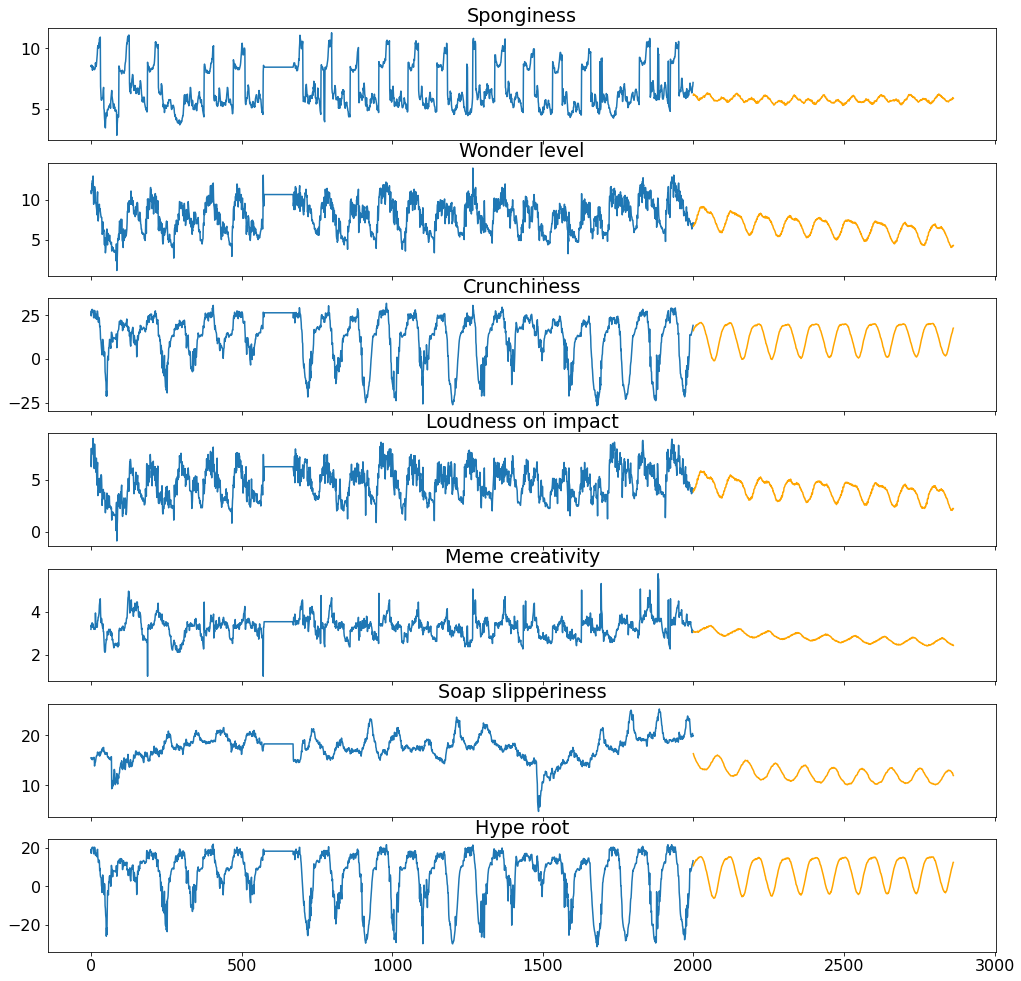

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future_up[0,:,i])), future_up[0,:,i])
    axs[i].plot(np.arange(len(future_up[0,:,i]), len(future_up[0,:,i])+TELESCOPE), out[:,i], color='orange')
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()